In [ ]:
"""
File containing neurals networks used by the PPO agent in 
order to estimate value function and policy

Creation date: 27/02/2024
Last modif: 15/03/2024
By: Mehdi 
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size, max_mean, max_std=10):
        """
        Initialization of policy nektwork
        
        :params input_size: int
            Size of input, basically, observation space dim 
        :params output size: int 
            Size of output, basically, action space dim 
        """
        super(PolicyNetwork, self).__init__()

        # max value for bounded action space
        self.max_mean = max_mean
        self.max_std = max_std

        # layers for neural net
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.mean = nn.Linear(32, output_size)
        self.std = nn.Linear(32, output_size)

    def forward(self, obs):
        """
        Forward function 

        :params obs: array
            Observation vector
        """
        output = F.sigmoid(self.layer1(obs))
        output = F.sigmoid(self.layer2(output))

        # computes mean
        mean = F.sigmoid(self.mean(output))

        # compute std
        std = F.sigmoid(self.std(output))

        # scale mean and std
        mean = torch.multiply(self.max_mean, mean)
        std = torch.multiply(self.max_std, std)

        return mean, std

    def sample(self, mean, std):
        """
        Sample an action from current policy. 
        """
        z = torch.randn_like(std)
        if np.random.random() < 0.01:
            print("\nStandard deviation: ", std)
            print("Mean: ", mean, "\n")
        action = torch.clamp(mean + std * z, 0, self.max_mean)
        return action

    def log_prob(self, mean, std, action):
        z = (action - mean) / std
        log_prob = -0.5 * z**2 - std - 0.5 * np.log(2 * np.pi)
        # return torch.tensor(log_prob.sum(dim=-1))
        return torch.sum(log_prob, dim=-1)
    
    def inference(self, obs):
        """
        Inference function 

        :params obs: array
            Observation vector
        """
        mean, _ = self.forward(obs)

        return mean

class ValueNetwork(nn.Module):
    def __init__(self, input_size):
        """
        Initialization of value network. 

        :params input_size: int 
            Input shape, basically dimension of observation space.
        """
        super(ValueNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        value = self.output(x)
        return value

In [1]:
"""
Main file for creating environment openai gym friendly. 

Creation date: 24/02/2024
Last modification: 26/02/024
By: Mehdi EL KANSOULI 
"""

import numpy as np 
import gym 

from gym.spaces import Box, Dict


class SupplyChainPOC(gym.Env):

    def __init__(self, suppliers: dict):
        """
        Initialization of the environment.

        :params suppliers: dict 
            Keys are suppliers, values are dictionary with keys being demand, 
            sotck_max, stock_cost, lost_sell, transport_cost, sell_price.
        """

        # info on factory 
        self.prod_max = 500
        self.prod_cost = 3.
        self.excess_prod_cost = 2.
        self.excess_stock_cost = 10.
        self.sell_price = 10.

        # info on supliers 
        self.suppliers = suppliers
        self.nb_suppliers = len(suppliers.keys())

        # define action space
        self.action_space =  Dict({
            supplier: Box(low=np.array([0.]), 
                          high=np.array([self.prod_max]),
                          dtype=np.float64)
            for supplier in suppliers.keys()
        })

        # define state space (current stock + next day demand)
        self.state_space = Dict({
            supplier: Box(low=np.array([0., 50.]), 
                          high=np.array([val.get("stock_max"), 150]),
                          dtype=np.float64)
            for supplier, val in suppliers.items()
        })

        # define observation state 
        self.observation_space = self.state_space

    def reset(self):
        """
        Define specific setting for generating an episode. 
        """
        # define initial state (actual sells the next day) 
        initial_state = self.state_space.sample()

        # define corresponding observation 
        initial_obs = self._state_to_obs(initial_state)

        # instantiate 
        self.obs = initial_obs
        self.state = initial_state

        return self._normalize_obs(initial_obs), initial_state


    def step(self, action: dict):
        """
        Function to perform one step in the environment given an action. 

        :params action: int
        """
        # intitilaize reward and total prod
        reward = 0
        total_prod = 0
        penalties = 0
        action = self._denormalize_actions(action)
        if np.random.random() <= 0.001:
            print("Action: ", action)

        # get aciton for each supplier 
        for s, a in action.items():

            if a < 0:
                # raise ValueError("Production cannot be negative")
                penalties += 10
                a = 0

            # add to total prod
            total_prod += a

            # get supplier info 
            supplier = self.suppliers.get(s)
            
            # get total nb of products 
            total_ = self.state.get(s)[0] + a

            # get new stock and demand loss (retrieve demand)
            pivot = total_ - self.state.get(s)[1]

            if pivot >= 0:
                new_stock = pivot
                demand_loss = 0
                reward -= self.state.get(s)[1] * self.sell_price
            else:
                new_stock = 0
                demand_loss = - pivot 
                reward -= total_ * self.sell_price
                reward += supplier.get("lost_sell") * demand_loss
                        
            # compute excess stock and threshold new_stock to its limit 
            excess_stock = max(new_stock - supplier.get("stock_max"), 0) 
            new_stock = min(new_stock, supplier.get("stock_max"))

            # compute reward 
            reward_ = self._reward(supplier, new_stock, demand_loss, a, 
                                   excess_stock)

            # add to overall reward 
            reward += reward_ 

            # update state for this distributor (new stock & new demand)
            self.state[s] = np.array([new_stock, np.random.uniform(50, 150)])
        
        # compute cost of prod 
        reward += total_prod * self.prod_cost

        # add cost of excessive prod 
        reward += max(total_prod - self.prod_max, 0) * self.excess_prod_cost

        # add penalties (e.g. pred neg actions)
        profit = - reward
        reward += penalties

        reward = self._normalize_reward(reward)  # transform in a real reward
        self.obs = self._state_to_obs(self.state)

        return self._normalize_obs(self.obs), reward, profit
    
    def _normalize_reward(self, reward):
        """
        Normalize the reward. Multiplication by -1 in order 
        to have a cost instead of a reaward. 
        """
        return - reward / (self.prod_cost * 100 * len(self.suppliers))
    
    def _normalize_obs(self, obs):
        """
        """
        norm_obs = []
        for distrib, arr in obs.items():
            x, y = arr.copy()
            x /= self.suppliers.get(distrib).get("stock_max")
            y /= (self.prod_max / len(self.suppliers.keys()))
            norm_obs += [x, y]
        return np.array(norm_obs)
            
    def _denormalize_actions(self, actions):
        """
        Function that takes as input normalize actions and denormalize 
        them

        :params actions: dict 
            Dictionary of normalized actions 
        
        :return dict 
            Denormalized actions 
        """
        denorm_action = {}
        for key, value in actions.items():
            real_action = value * (self.prod_max / len(self.suppliers.keys()))
            denorm_action[key] = real_action

        return denorm_action
    
    def _state_to_obs(self, state):
        """
        Noise is added to state corresonding to a non-perfect forecast of next day 
        consumption. 
        """
        obs = state.copy()
        for s, v in state.items():
            rand = np.array([0, np.random.normal(0, 5)])
            obs[s] = v + rand
        return obs
    
    def _reward(self, supplier:dict, stock, demand_loss, nb, excess):
        """
        Function to compute reward associated to exactly one distrib
        """
        # initialize reward
        reward_ = 0

        # add stock cost
        reward_ += stock * supplier.get("stock_cost")  

        # add effect of sells lost
        reward_ += demand_loss * supplier.get("lost_sell")  

        # add cost of transporting nb products
        reward_ += supplier.get("transport_cost")(nb)  

        # pay excess of stock 
        reward_ += excess * self.excess_stock_cost 

        return reward_      
    

class SupplyChainV0(gym.Env):
    
    def __init__(self, suppliers: dict):
        """
        Initialization of the environment.

        :params suppliers: dict 
            Keys are suppliers, values are dictionary with keys being demand, 
            sotck_max, stock_cost, lost_sell, transport_cost, sell_price.
        """
        # info on factory 
        self.prod_max = 250
        self.prod_cost = 1.
        self.excess_prod_cost = 2.
        self.excess_stock_cost = 5.

        # info on supliers 
        self.suppliers = suppliers
        self.nb_suppliers = len(suppliers.keys())

        # define action space
        self.action_space =  Dict({
            supplier: Box(low=np.array([0.]), 
                          high=np.array([self.prod_max]),
                          dtype=np.float64)
            for supplier in suppliers.keys()
        })

        # define state space (current stock + next day demand)
        self.state_space = Dict({
            supplier: Box(low=np.array([0., 50.]), 
                          high=np.array([val.get("stock_max"), 150]),
                          dtype=np.float64)
            for supplier, val in suppliers.items()
        })

        # define observation state 
        self.observation_space = self.state_space

    def reset(self):
        """
        Define specific setting for generating an episode. 
        """
        # define initial state (actual sells the next day) 
        initial_state = self.state_space.sample()

        # define corresponding observation 
        initial_obs = self._state_to_obs(initial_state)

        # instantiate 
        self.obs = initial_obs
        self.state = initial_state

        return initial_obs, initial_state

    def step(self, action: dict):
        """
        Function to perform one step in the environment given an action. 

        :params action: int
        """
        # intitilaize reward and total prod
        reward = 0
        total_prod = 0

        # get aciton for each supplier 
        for s, a in action.items():

            if a < 0:
                raise ValueError("Production cannot be negative")

            # add to total prod
            total_prod += a

            # get supplier info 
            supplier = self.suppliers.get(s)
            
            # get total nb of products 
            total_ = self.state.get(s)[0] + a

            # get new stock and demand loss (retrieve demand)
            pivot = total_ - self.state.get(s)[1]

            if pivot >= 0:
                new_stock = pivot
                demand_loss = 0
                # compute earnings
                reward -= self.state.get(s)[1] * supplier.get("sell_price", 0.)
            else:
                new_stock = 0
                demand_loss = - pivot 
                # compute earnings
                reward -= total_ * supplier.get("sell_price", 0.)
                        
            # compute excess stock and threshold new_stock to its limit 
            excess_stock = max(new_stock - supplier.get("stock_max"), 0) 
            new_stock = min(new_stock, supplier.get("stock_max"))

            # compute reward 
            costs = self._all_costs(supplier, new_stock, demand_loss, a, 
                                    excess_stock)

            # add to overall reward 
            reward += costs

            # update state for this distributor (new stock & new demand)
            self.state[s] = np.array([new_stock, np.random.uniform(50, 150)])
        
        # compute cost of prod 
        reward += total_prod * self.prod_cost

        # add cost of excessive prod 
        reward += max(total_prod - self.prod_max, 0) * self.excess_prod_cost

        # add penalties (e.g. pred neg actions)
        reward *= -1
        profit = reward

        # normalize the reward and update observation
        reward = self._normalize_reward(reward)  # transform in a real reward
        self.obs = self._state_to_obs(self.state)

        return self.obs, reward, profit
    
    def _normalize_reward(self, reward):
        """
        Normalize the reward. Multiplication by -1 in order 
        to have a cost instead of a reaward. 
        """
        return reward / 100
    
    def _state_to_obs(self, state):
        """
        Noise is added to state corresonding to a non-perfect forecast of next day 
        consumption. 
        """
        obs = state.copy()
        for s, v in state.items():
            stock, next_cons = v
            forecast = np.clip(next_cons + np.random.normal(0, 10), 50, 150)
            obs[s] = np.array([stock, forecast])
        return obs
    
    def _all_costs(self, supplier:dict, stock, demand_loss, nb, excess):
        """
        Function to compute reward associated to exactly one distrib
        """
        # initialize reward
        cost = 0

        # add stock cost
        cost += stock * supplier.get("stock_cost")  

        # add effect of sells lost
        cost += demand_loss * supplier.get("lost_sell")  

        # add cost of transporting nb products
        cost += supplier.get("transport_cost")(nb)  

        # pay excess of stock 
        cost += excess * self.excess_stock_cost 

        return cost      


In [2]:
"""
Main file to run. 

Command: $ python main.py

Creation date: 27/02/2024
Last modif: 27/02/2024
By: Mehdi 
"""

import numpy as np 
import matplotlib.pyplot as plt 

from environment.env import SupplyChainPOC, SupplyChainV0
from agent.agent import BasicAgent, PPOAgent
from agent_trainer.main_trainer import PPOTrainer, normalize_obs


def inference(env, agent, episode_length, suppliers):
    """
    Inference.

    :params env: gym env
        Supply chain env
    :params agent: gym friendly agent.
        From agent.py 
    """
    # reset env
    env.reset()

    # array of reward
    rewards = np.zeros(episode_length)
    states = [None] * (episode_length + 1)
    observations = [None] * (episode_length + 1)
    actions = [None] * episode_length
    profits = [None] * episode_length

    # start episode
    obs, state = env.reset()
    observations[0] = obs 
    states[0] = state 

    for i in range(episode_length):

        # get action from the agent
        action = agent.inference(normalize_obs(obs, suppliers))

        # perform one step 
        new_obs, reward, profit = env.step(action)

        # store result 
        rewards[i] = reward
        actions[i] = action
        observations[i+1] = new_obs
        states[i+1] = env.state
        profits[i] = profit

    results = {
        "states": states, 
        "obs": observations,
        "rewards": rewards, 
        "actions": actions, 
        "profits": profits
    }

    return results


def main():
    """
    In developpement,
    """
    # define problem
    suppliers = {
    "distrib_1": {
        "demand": 100, 
        "stock_max": 200, 
        "stock_cost": 3,
        "lost_sell": 5, 
        "transport_cost": lambda x: 10 * (x // 10 + 1), 
        "sell_price": 5
    }, 
    "distrib_2": {
        "demand": 100, 
        "stock_max": 200, 
        "stock_cost": 3,
        "lost_sell": 5, 
        "transport_cost": lambda x: 10 * (x // 10 + 1), 
        "sell_price": 5
    }  
    }

    # define agent and env 
    agent = BasicAgent(suppliers)
    env = SupplyChainV0(suppliers)

    # perform an episode
    results = inference(env, agent, suppliers)
    rewards = results.get("rewards")
    avg_profit = np.mean(results.get("profits"))

    print("Rewards: ", rewards)
    print("Profits: ", results.get("profits"))
    print("Avg profit: ", avg_profit)


def main_v2(nb_episodes=100, episode_length=1000, nb_epochs=1):
    """
    """
    # define problem
    suppliers = {
    "distrib_1": {
        "demand": 100, 
        "stock_max": 200, 
        "stock_cost": 3.,
        "lost_sell": 3., 
        "transport_cost": lambda x: 0., 
        "sell_price": 5.
    }, 
    "distrib_2": {
        "demand": 100, 
        "stock_max": 200, 
        "stock_cost": 3.,
        "lost_sell": 3., 
        "transport_cost": lambda x: 0., 
        "sell_price": 5.
    }  
    }

    # define agent
    agent = PPOAgent(
        suppliers=suppliers, 
        obs_dim=4, 
        gamma=0.9
    )

    # define env 
    env = SupplyChainV0(suppliers)

    results = inference(env, agent, episode_length=10, suppliers=suppliers)
    print("Actions: ", results.get("actions"))
    print("\nObservations: ", results.get("obs"))
    print("\nReward: ", results.get("rewards"))
    print("\nProfits: ", results.get("profits"))

    rewards = PPOTrainer(
        agent=agent, 
        env=env, 
        suppliers=suppliers,
        nb_episode=nb_episodes, 
        episode_length=episode_length,
        nb_epochs=nb_epochs
    )

    plt.plot(np.arange(len(rewards)), rewards)
    plt.show()

    # print("rewards: ", rewards)
    # perform an episode
    results = inference(env, agent, episode_length=5, suppliers=suppliers)
    print("Actions: ", results.get("actions"))
    print("\nObservations: ", results.get("obs"))
    print("\nReward: ", results.get("rewards"))
    print("\nProfits: ", results.get("profits"))


    # test dumb agent
    # define agent and env 
    basic_agent = BasicAgent(suppliers)

    # perform an episode
    results = inference(env, basic_agent, episode_length=5, suppliers=suppliers)
    profit = np.sum(results.get("profits"))

    print("\nDumb agent profit: ", profit)

if __name__ == "__main__":
    main_v2(
        nb_episodes=2000, 
        episode_length=50, 
        nb_epochs=10
    )





Actions:  [{'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}, {'distrib_1': 141.0365753173828, 'distrib_2': 134.65467834472656}]

Observations:  [OrderedDict([('distrib_1', array([ 88.62508647, 127.79534406])), ('distrib_2', array([69.13978934, 86.31198188]))]), OrderedDict([('distrib_1', array([ 91.52387469, 126.29336177])), ('distrib_2', array([109.06293889, 111.60216842]))]), OrderedDict([('distrib_1', array([126.27348232, 121.12595626])), (

KeyboardInterrupt: 

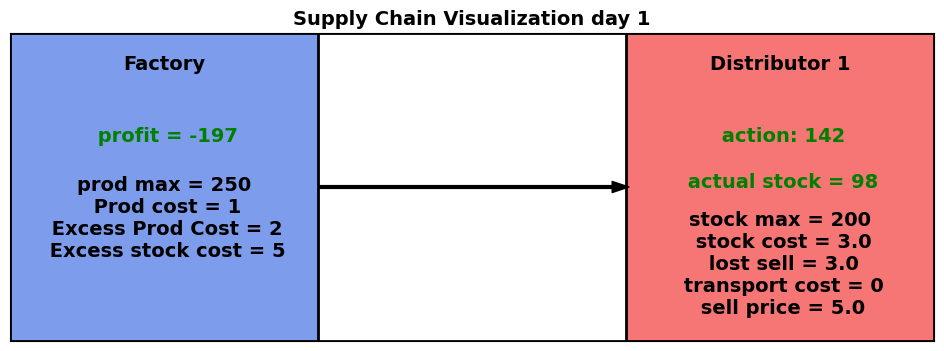

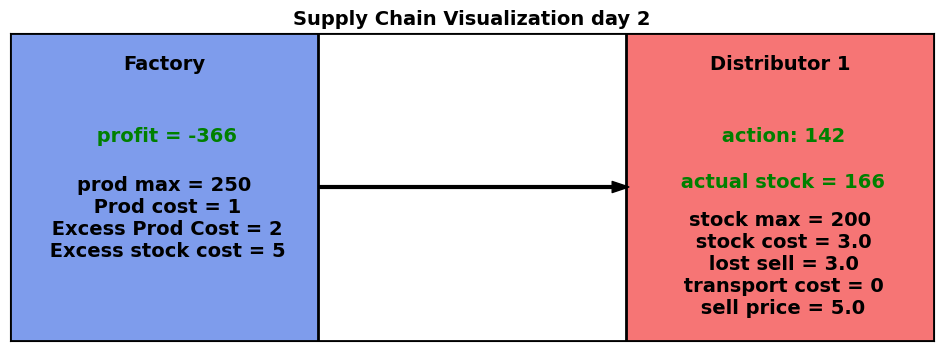

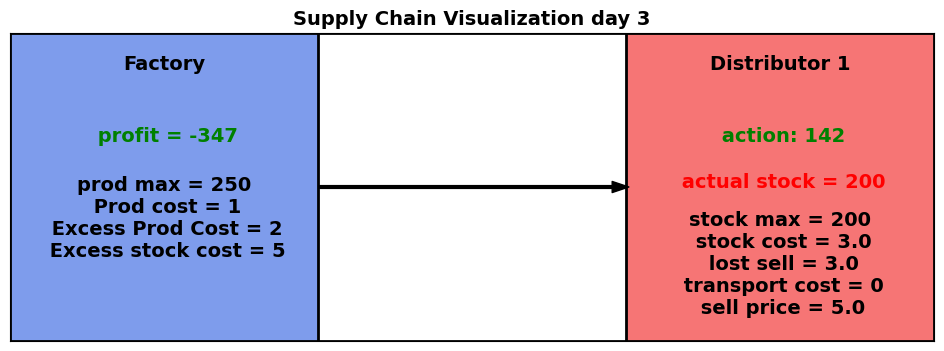

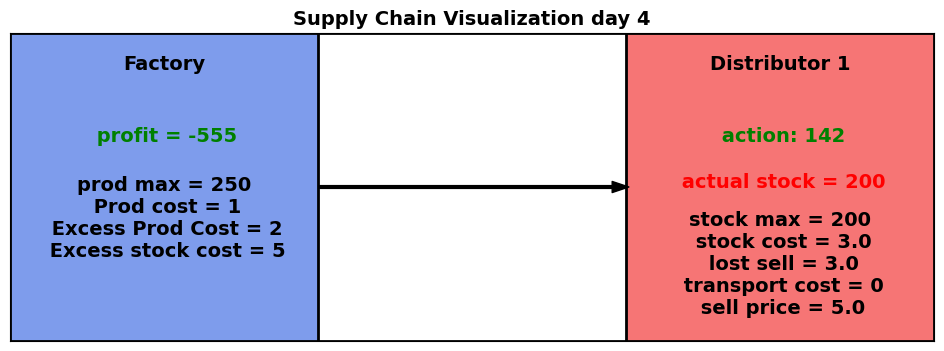

In [194]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

def create_adaptive_colored_grid_1(results, factory_char, red , blue, suppliers):
       # make a string for suppliers 1 characteristique
        distributor_1_char = f"stock max = {suppliers['distrib_1']['stock_max']}\n stock cost = {suppliers['distrib_1']['stock_cost']}\n lost sell = {suppliers['distrib_1']['lost_sell']}\n transport cost = {suppliers['distrib_1']['transport_cost']}\n sell price = {suppliers['distrib_1']['sell_price']}"
        
        for i in range(0, len(results['obs'])-1):
          
            #action string for distributor 1
            distributor_1_ac = f"\n action: {round(results['actions'][i]['distrib_1'])}"
            distributor_1_stock = f"\n actual stock = {round(results['obs'][i]['distrib_1'][0])}"
            factory_profit = f"\n profit = {round(results['profits'][i])}"
            # Initialize a white grid for 1x3   
            grid = np.ones((1, 3, 3))

            
            # Fill in the blue box on the left
            grid[0, 0] = blue

            # Fill in the red box on the right
            grid[0, 2] = red

            # Create the plot
            fig, ax = plt.subplots(figsize=(12, 4))
            ax.imshow(grid, extent=[0, 3, 0, 1])

            # Draw the grid lines
            for x in range(4):
                ax.axvline(x=x, color='black', linewidth=2)

            # Add a horizontal line to the top and bottom
            ax.axhline(y=0, color='black', linewidth=2)
            ax.axhline(y=1, color='black', linewidth=2)


            # Factory text
            ax.text(0.5, 0.9, 'Factory', color='black', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(0.5, 0.7, factory_profit, color='green', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(0.5, 0.4, factory_char, color='black', ha='center', va='center', fontsize=14, fontweight='bold')


            #stock text color 
            if round(results['obs'][i]['distrib_1'][0]) == suppliers['distrib_1']['stock_max']:
                stock_color = 'red'
            else:
                 stock_color = 'green'
            # Distributor 1 text
            ax.text(2.5, 0.9, 'Distributor 1', color='black', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 0.7, distributor_1_ac, color='green', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 0.55, distributor_1_stock, color=stock_color, ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 0.25, distributor_1_char, color='black', ha='center', va='center', fontsize=14, fontweight='bold')


            ax.annotate('', xy=(2.065, 0.5), xytext=(0.95, 0.5),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))

            # Remove ticks
            ax.set_xticks([])
            ax.set_yticks([])

            ax.set_title(f'Supply Chain Visualization day {i+1}', fontsize=14, fontweight='bold')
            plt.show()

def create_adaptive_colored_grid_2(results, factory_char, red , blue, suppliers):
    for i in range(0, len(results['obs'])-1):
            #action string for distributor 1
            distributor_1_ac = f"\n action: {round(results['actions'][i]['distrib_1'])}"
            distributor_1_stock = f"\n actual stock = {round(results['obs'][i]['distrib_1'][0])}"
            factory_profit = f"\n profit = {round(results['profits'][i])}"
            distributor_1_char = f"stock max = {suppliers['distrib_1']['stock_max']}\n stock cost = {suppliers['distrib_1']['stock_cost']}\n lost sell = {suppliers['distrib_1']['lost_sell']}\n sell price = {suppliers['distrib_1']['sell_price']}"

            distributor_2_ac = f"\n action: {round(results['actions'][i]['distrib_2'])}"
            distributor_2_stock = f"\n actual stock = {round(results['obs'][i]['distrib_2'][0])}"
            distributor_2_char = f"stock max = {suppliers['distrib_2']['stock_max']}\n stock cost = {suppliers['distrib_2']['stock_cost']}\n lost sell = {suppliers['distrib_2']['lost_sell']}\n sell price = {suppliers['distrib_2']['sell_price']}"

            # Initialize a white grid for 1x3
            grid = np.ones((3, 3, 3))


            # Fill in the blue box on the left
            grid[1, 0] = blue

            # Fill in the red box on the right
            grid[0, 2] = red

            # Fill in the red box on the right
            grid[2, 2] = red

            # Create the plot
            fig, ax = plt.subplots(figsize=(12, 12))
            ax.imshow(grid, extent=[0, 3, 0, 3])

          
       
            # Factory text
            ax.text(0.5, 1.9, 'Factory', color='black', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(0.5, 1.7, factory_profit, color='green', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(0.5, 1.4, factory_char, color='black', ha='center', va='center', fontsize=14, fontweight='bold')

             #stock text color 
            if round(results['obs'][i]['distrib_1'][0]) == suppliers['distrib_1']['stock_max']:
                stock_color = 'red'
            else:
                 stock_color = 'green'


            # Distributor 1 text
            ax.text(2.5, 0.9, 'Distributor 1', color='black', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 0.7, distributor_1_ac, color='green', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 0.55, distributor_1_stock, color=stock_color, ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 0.25, distributor_1_char, color='black', ha='center', va='center', fontsize=14, fontweight='bold')

             #stock text color 
            if round(results['obs'][i]['distrib_2'][0]) == suppliers['distrib_2']['stock_max']:
                stock_color = 'red'
            else:
                 stock_color = 'green'
            
            # Distributor 2 text
            ax.text(2.5, 2.9, 'Distributor 2', color='black', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 2.7, distributor_2_ac, color='green', ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 2.55, distributor_2_stock, color=stock_color, ha='center', va='center', fontsize=14, fontweight='bold')
            ax.text(2.5, 2.25, distributor_2_char, color='black', ha='center', va='center', fontsize=14, fontweight='bold')

            ax.annotate('', xy=(2, 0.5), xytext=(1, 1.5),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))
            
            ax.annotate('', xy=(2, 2.5), xytext=(1, 1.5),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))

            # Remove ticks
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Supply Chain Visualization day {i+1}', fontsize=14, fontweight='bold')
            plt.show()


def visualization_factory(env, results, suppliers):
    factory_char = f"prod max = {env.prod_max}\n Prod cost = {env.prod_cost}\n Excess Prod Cost = {env.excess_prod_cost}\n Excess stock cost = {env.excess_stock_cost}"

    red = [246/255, 117/255, 117/255]
    blue = [126/255, 156/255, 236/255]
    n_red_boxes = len(suppliers)
    if n_red_boxes == 1:
        create_adaptive_colored_grid_1(results, factory_char, red, blue, suppliers)

    
    if n_red_boxes == 2:
        create_adaptive_colored_grid_2(results, factory_char, red, blue, suppliers)
        
    if n_red_boxes == 3:
        # Initialize a white grid for 1x3
        grid = np.ones((5, 3, 3))

        # Set the color for red and blue boxes
        red = [1, 0, 0]
        blue = [0, 0, 1]

        # Fill in the blue box on the left
        grid[2, 0] = blue

        # Fill in the red box on the right
        grid[0, 2] = red

        # Fill in the red box on the right
        grid[2, 2] = red

        grid[4, 2] = red

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 18))
        ax.imshow(grid, extent=[0, 3, 0, 5])

        # Draw the grid lines
        for x in range(4):
            ax.axvline(x=x, color='black', linewidth=2)

        for y in range(5):
            ax.axhline(y=y, color='black', linewidth=2)

        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()


class MockEnv:
    prod_max = 250
    prod_cost = 1
    excess_prod_cost = 2
    excess_stock_cost = 5

env = MockEnv()
suppliers = ['distributor 1', 'distributor 2']  # List of supplier names
episode_length = 5  # Number of timesteps to visualize
# Results from inference function

suppliers = {
"distrib_1": {
    "demand": 100, 
    "stock_max": 200, 
    "stock_cost": 3.,
    "lost_sell": 3., 
    "transport_cost": 0, 
    "sell_price": 5.
}  
}
results = {
    'actions': [{'distrib_1': 142.0233917236328, 'distrib_2': 86.35302734375} for _ in range(6)],
    'obs': [
        OrderedDict([
            ('distrib_1', np.array([98.26629274, 68.57497631])),
            ('distrib_2', np.array([126.35707092, 115.45719633]))
        ]),
        OrderedDict([
            ('distrib_1', np.array([165.90851976, 106.55535449])),
            ('distrib_2', np.array([113.33479582,  81.47699941]))
        ]),
        OrderedDict([
            ('distrib_1', np.array([200.,  67.5831895])),
            ('distrib_2', np.array([122.69211809, 121.53640278]))
        ]),
        OrderedDict([
            ('distrib_1', np.array([200.,  77.45273932])),
            ('distrib_2', np.array([78.90385102, 62.82873937]))
        ]),
        OrderedDict([
            ('distrib_1', np.array([200., 119.09857686])),
            ('distrib_2', np.array([102.13985767, 105.77195677]))
        ])
    ],
    'rewards': [-1.9732403, -3.65725611, -3.4731917, -5.54867959, -1.75256708],
    'profits': [-197.3240300488289, -365.7256105811316, -347.3191703117975, -554.8679587695542, -175.2567082804307]
}
visualization_factory(env, results, suppliers)


Standard deviation:  tensor([[7.3996, 5.8389]], grad_fn=<MulBackward0>)
Mean:  tensor([[108.1039, 134.2706]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[7.4072, 5.8400]], grad_fn=<MulBackward0>)
Mean:  tensor([[108.0806, 134.2972]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[7.4037, 5.8384]], grad_fn=<MulBackward0>)
Mean:  tensor([[108.1247, 134.2998]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[7.4047, 5.8391]], grad_fn=<MulBackward0>)
Mean:  tensor([[108.0966, 134.2823]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[7.4026, 5.8430]], grad_fn=<MulBackward0>)
Mean:  tensor([[107.9985, 134.2243]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[7.3994, 5.8402]], grad_fn=<MulBackward0>)
Mean:  tensor([[108.0409, 134.2841]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[7.3999, 5.8398]], grad_fn=<MulBackward0>)
Mean:  tensor([[108.0672, 134.2386]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[7.4050, 5.

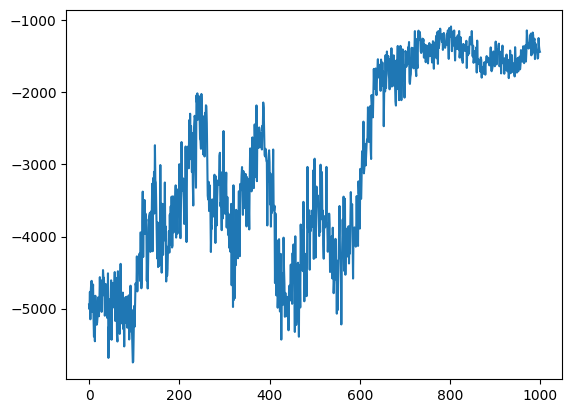

{'states': [OrderedDict([('distrib_1', array([ 4.0337595 , 60.43532694])), ('distrib_2', array([ 97.89253303, 109.50870522]))]), OrderedDict([('distrib_1', array([ 4.0337595 , 60.43532694])), ('distrib_2', array([ 97.89253303, 109.50870522]))]), OrderedDict([('distrib_1', array([ 4.0337595 , 60.43532694])), ('distrib_2', array([ 97.89253303, 109.50870522]))]), OrderedDict([('distrib_1', array([ 4.0337595 , 60.43532694])), ('distrib_2', array([ 97.89253303, 109.50870522]))]), OrderedDict([('distrib_1', array([ 4.0337595 , 60.43532694])), ('distrib_2', array([ 97.89253303, 109.50870522]))]), OrderedDict([('distrib_1', array([ 4.0337595 , 60.43532694])), ('distrib_2', array([ 97.89253303, 109.50870522]))])], 'obs': [OrderedDict([('distrib_1', array([ 14.44448062, 124.11654319])), ('distrib_2', array([  5.55481191, 150.        ]))]), OrderedDict([('distrib_1', array([  0.        , 137.74886758])), ('distrib_2', array([  0.        , 132.70285269]))]), OrderedDict([('distrib_1', array([  0.,

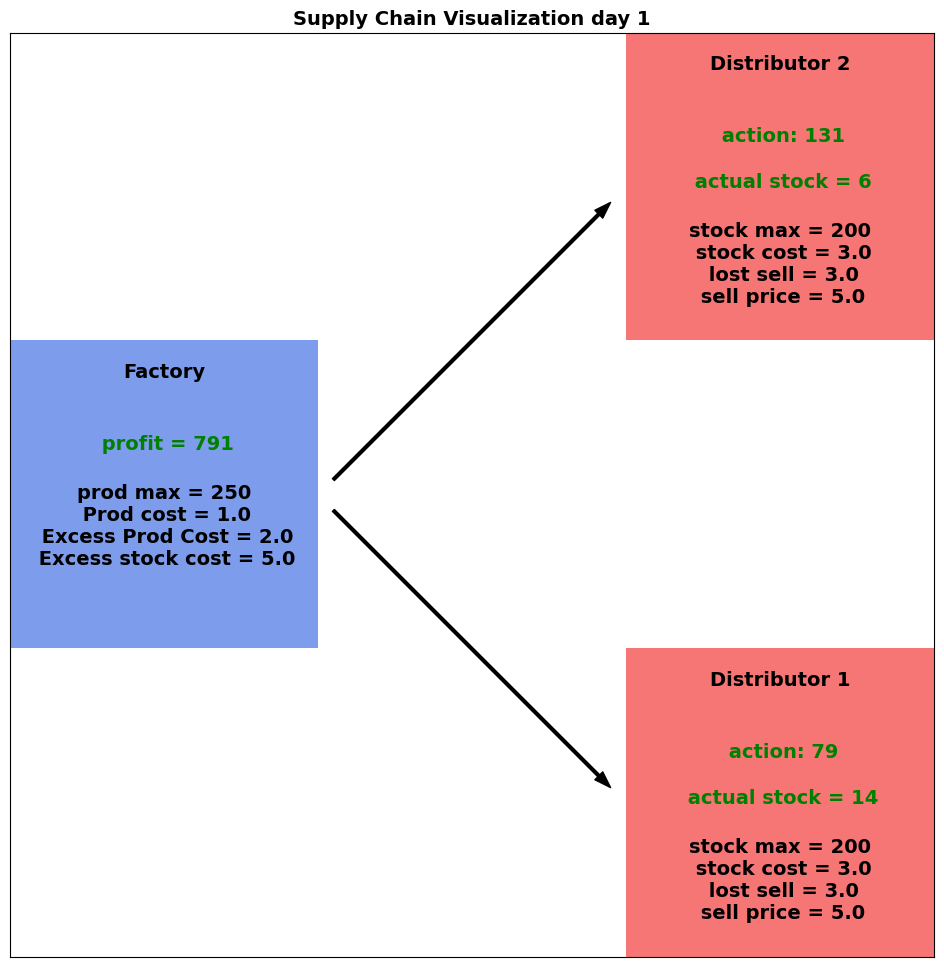

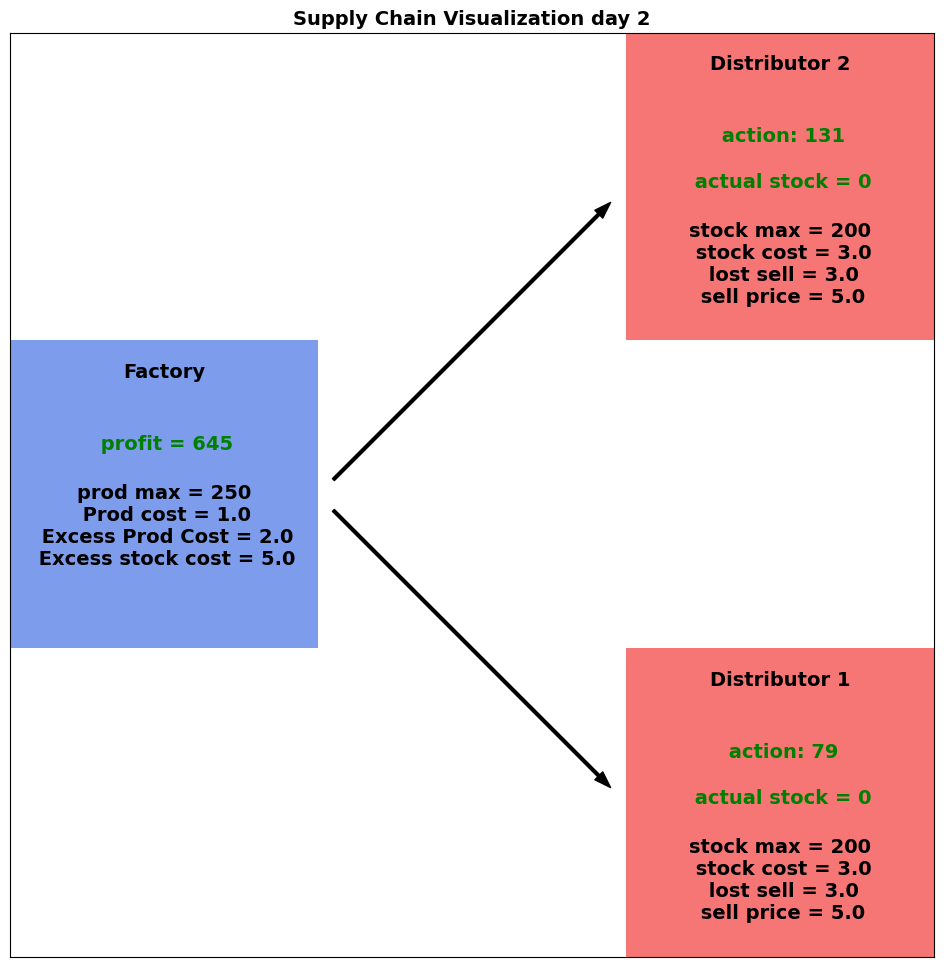

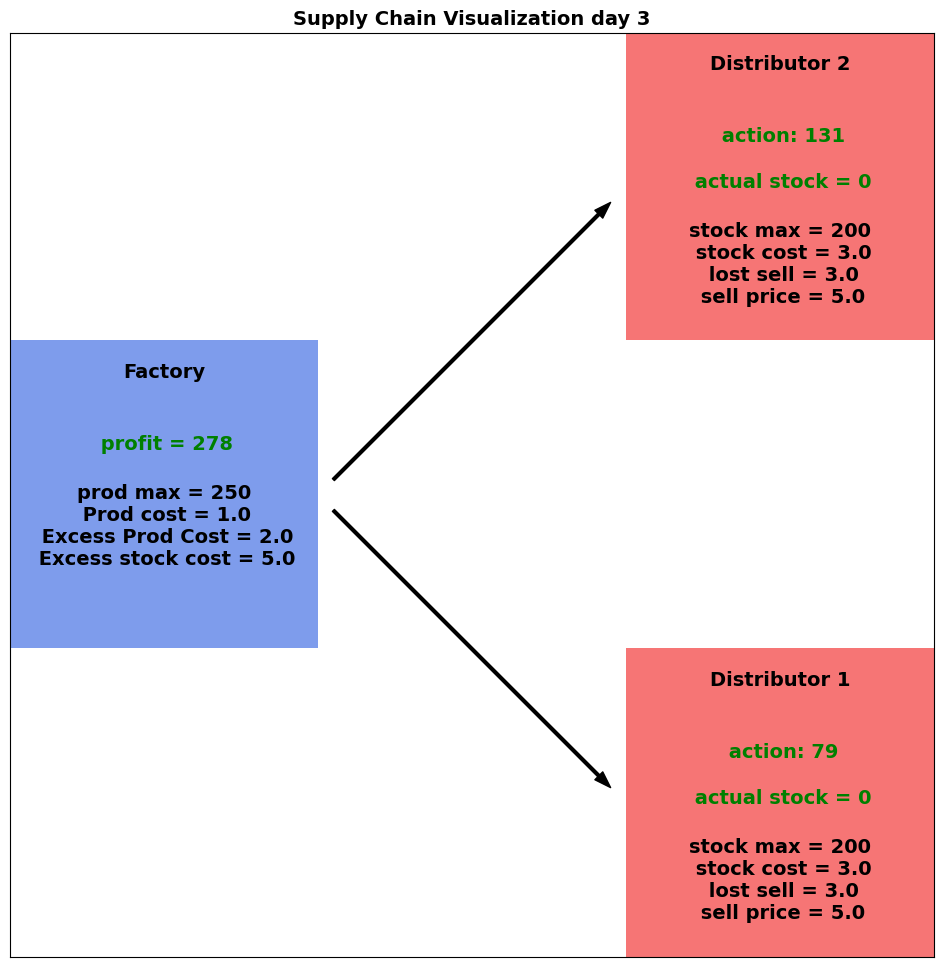

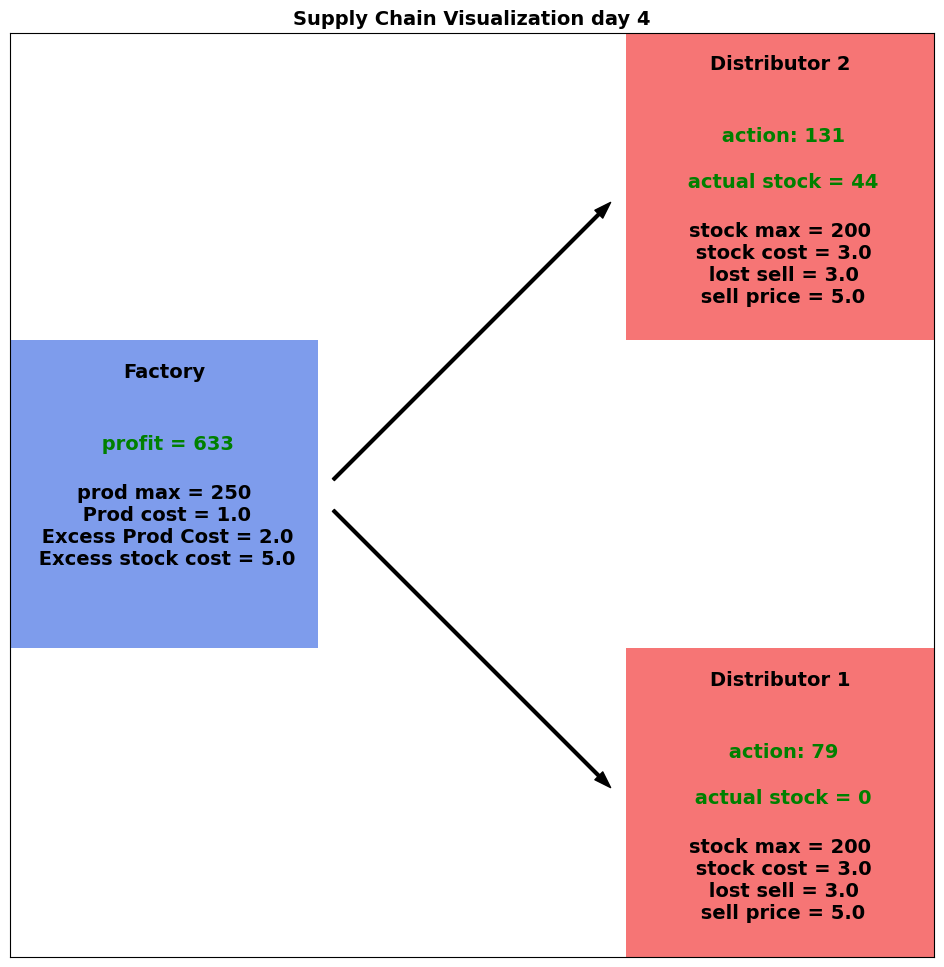

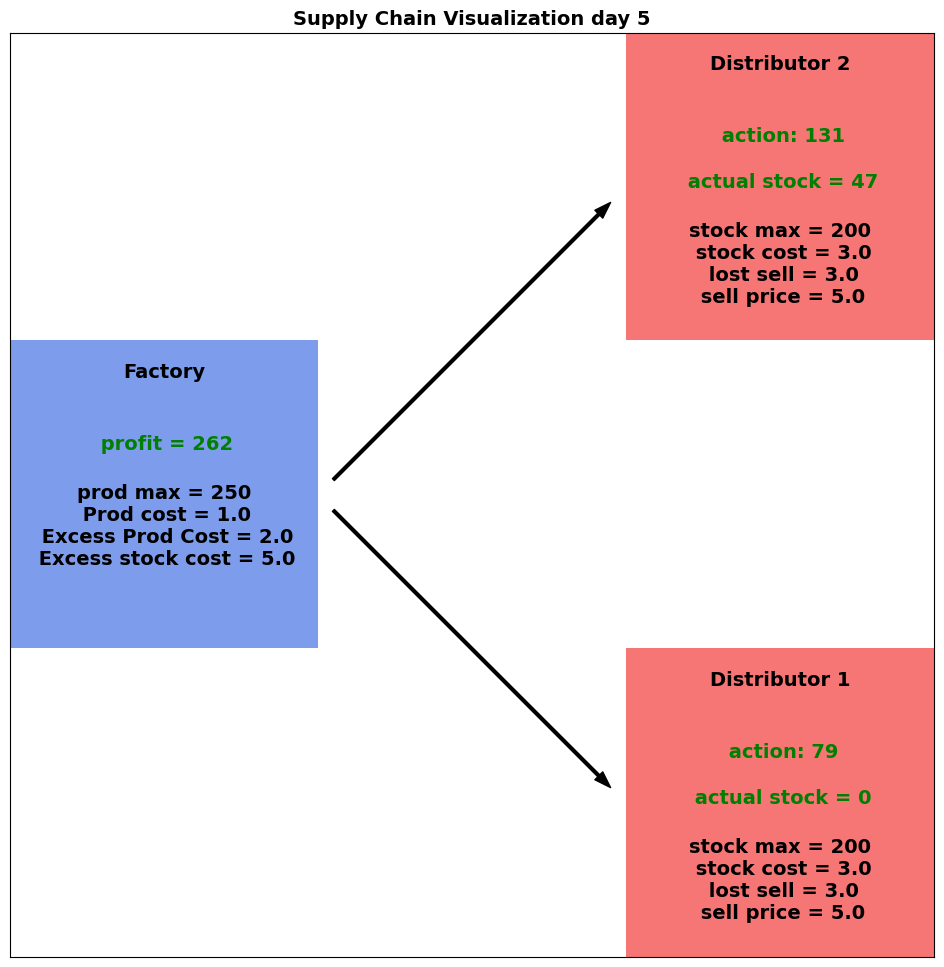


Dumb agent profit:  -1985.2780497283275


In [190]:
import matplotlib.pyplot as plt
import numpy as np

 # define problem
suppliers = {
"distrib_1": {
    "demand": 100, 
    "stock_max": 200, 
    "stock_cost": 3.,
    "lost_sell": 3., 
    "transport_cost": lambda x: 0., 
    "sell_price": 5.
}, 
"distrib_2": {
    "demand": 100, 
    "stock_max": 200, 
    "stock_cost": 3.,
    "lost_sell": 3., 
    "transport_cost": lambda x: 0., 
    "sell_price": 5.
}  
}

# define agent
agent = PPOAgent(
    suppliers=suppliers, 
    obs_dim=4, 
    gamma=0.9
)

# define env 
env = SupplyChainV0(suppliers)

n_suppliers = len(suppliers)  
episode_length = 1000

rewards = PPOTrainer(
    agent=agent, 
    env=env, 
    suppliers=suppliers,
    nb_episode=episode_length, 
    episode_length=episode_length,
    nb_epochs=10
)

plt.plot(np.arange(len(rewards)), rewards)
plt.show()

# print("rewards: ", rewards)
# perform an episode
results = inference(env, agent, episode_length=5, suppliers=suppliers)
print(results)
print("Actions: ", results.get("actions"))
print("\nObservations: ", results.get("obs"))
print("\nReward: ", results.get("rewards"))
print("\nProfits: ", results.get("profits"))

visualization_factory(env, results, suppliers)

# test dumb agent
# define agent and env 
basic_agent = BasicAgent(suppliers)

# perform an episode
results = inference(env, basic_agent, episode_length=5, suppliers=suppliers)
profit = np.sum(results.get("profits"))

print("\nDumb agent profit: ", profit)